# Stellarium API - Data gathering

## Information

#### What this jupyter notebook does
This jupyter notebook can be used to extract data from Stellarium using the Stellarium remote control plugin that can allow for HTTP requests to be sent to Stellarium.

#### Stellarium?
Stellarium is an open-source free-software planetarium, licensed under the terms of the GNU General Public License version 2, available for Linux, Windows, and macOS. A port Stellarium called Stellarium Mobile is available for Android, iOS, and Symbian as a paid version, being developed by Noctua Software. All versions use OpenGL to render a realistic projection of the night sky in real time.
[Source: wikipedia](https://en.wikipedia.org/wiki/Stellarium_(software))

### Useful resources

[Official Stellarium website](http://stellarium.org/)

[How to use Stellarium HTTP API, by Laura Durieux](https://medium.com/@lauradurieux/how-to-use-stellarium-http-api-f0942d2c8820) contains useful information on how to set things up.

For other available API calls, [visit the remoteControlApi webpage](https://stellarium.org/doc/head/remoteControlApi.html)

## How to set things up
Using the jupyter notebooks provided herein requires having Python 3 and Stellarium installed. 

[Get Stellarium here](http://stellarium.org/)

There are a couple of necessary steps that one needs to take before they can use the provided jupyter notebooks.

1. **Enable the remote control plugin**. Open Stellarium and press F11 on the keyboard to get out of full screen mode. Then, press F2 to bring up the Configuration menu. On the top pane, click the Plugins tab. On the left, navigate to Remote Control. Check the *Load at startup* checkbox. Then close the window and restart Stellarium. Press F11, then F2, navigate back to the Remote Control page, and click configure. You need to check the two boxes on top, that read "Server enabled", and "Enable automatically on startup" Make sure the port number reads **8090**. If you would like to use a different port, you will have to manually update that number in the notebooks as well. We haven't tried changing the port. Click Save settings and close the window. Restart Stellarium. *Note that you will only have to do this once.*
2. **Time zone - location settings**. Press F6 to bring up the Location window. You will need to uncheck the box that reads *"Get location from Network"*, check *"Use custom time zone"*, and uncheck *"enable daylight saving time"*. Set the Country field to *"___"*, and the Time zone to *"UTC+00:00"*. *Note that we have not found a command that can do those things using the API. You will have to change those settings each time you start Stellarium for the purpose of using the jupyter notebook

## Required packages

In [1]:
import urllib.request # URL handling modules
from bs4 import BeautifulSoup # pulling data out of HTML
import numpy as np # cientific computing
import datetime # basic date and time types
import jdcal # functions for converting between Julian dates and calendar dates
import pandas as pd # data analysis
from tqdm import tqdm # progress bars
import pickle # object serialization
import getpass # group work

## Function definitions

In [2]:
# For personalized global variable
baseurl = 'http://localhost:8090/api/'
if getpass.getuser() == 'mark':
    baseurl = 'http://10.0.0.2:8090/api/'
print(baseurl)

http://10.0.0.2:8090/api/


In [3]:
def post_request(command,values):
    '''
    This function is used to send a POST request to the API,
    where the options are defined in a dictionary.
    These kinds of requests are used to make a change on Stellarium,
    such us to change the current time or location.
    '''
    url = baseurl + command
    data = urllib.parse.urlencode(values)
    data = data.encode('ascii') # data should be bytes
    req = urllib.request.Request(url, data)
    with urllib.request.urlopen(req) as response:
       x = response.read()
    return x

In [4]:
def get_request(command):
    '''
    This function is used to send a GET request to the API. No options required.
    These kinds of requests are used to retrieve data from Stellarium.
    '''
    url = baseurl + command
    req = urllib.request.Request(url)
    with urllib.request.urlopen(req) as response:
       html = response.read()
    return html

In [5]:
def locate_line(soup,elm):
    '''
    This function is used to parse the html retrieved using the 
    get_request function. It tries to find the line in which 
    the string passed by the elm variable appears and return what's after that.
    It's purpose is to extract a specific piece of information and return it as text,
    such as the hour angle or the distance from the sun.
    '''
    return [line.replace(elm,'').strip() for line in soup.prettify().split('\n') if elm in line][0]

In [6]:
def hrmnsec_to_hr(time):
    """
    Converts a string of the form '1h10m10.59s' to
    a floating point real number corresponding to hours
    """
    return float(time.split('h')[0].strip()) + \
    float(((time.split('h')[1]).split('m'))[0])/60. + \
    float((time.split('h')[1]).split('m')[1].replace('s',''))/(60.**2)

In [7]:
def ang_to_real(angle):
    """
    Converts a string representing an angle of the form '+4°57\'33.4"'
    to the corresponding angle in degrees.
    """
    return float(angle.replace('"','').split('°')[0]) + \
    float((angle.replace('"','').split('°')[1]).split("'")[0])/60.00 + \
    float((angle.replace('"','').split('°')[1]).split("'")[1])/(60.0**2)

In [8]:
def get_location(body_name):
    '''
    This function sends a GET request to retrieve information for a given
    celestial body. It returns a python list containing the quantities we
    are interested in.
    '''
    call = 'objects/info?name=' + body_name
    # API call
    html = get_request(call)
    soup = BeautifulSoup(html,'html.parser')
    
    # Get RA, Dec.
    [ra, dec] = locate_line(soup,'RA/Dec (on date):').split('/')
    # get Az. Alt.
    [az, alt] = locate_line(soup,'Az./Alt.:').split('/')
    # get distance from Earth (in AU)
    distEarth = float(locate_line(soup,'Distance:').split('AU')[0].strip())
    # get distance from the Sun (in AU)
    if body_name != 'Sun':
        distSun = float(locate_line(soup,'Distance from Sun:').split('AU')[0].strip())
    else:
        distSun = 0.00
    const = locate_line(soup,'IAU Constellation:')
    # Parse times, angles and convert to float
    ra = hrmnsec_to_hr(ra)
    dec = ang_to_real(dec)
    az = ang_to_real(az)
    alt = ang_to_real(alt.replace(' (apparent)','').strip())
    return [ra,dec,az,alt,distEarth,distSun,const]

In [9]:
def update_location(lat,long):
    """
    Use the API to change the location of the observer on Earth .
    Latitude corresponds to degrees North
    Longitude corresponds to degrees EAST << be careful!
    """
    url = 'location/setlocationfields'
    values = {'latitude' : str(lat),
          'longitude' : str(long),
         'altitude' : '0.00'}
    res = post_request(url,values)

In [10]:
def update_time(JD):
    """
    Use the API to change the universal time (JD) 
    for which the quantities are reported.
    The unit is Julian Day
    https://en.wikipedia.org/wiki/Julian_day
    """
    url = 'main/time'
    values = {'time' : JD,
          'timerate' : 0.00}
    res = post_request(url,values)

In [11]:
def get_JD_from_date(year,month,day):
    """
    Convert calendar day to Julian Day
    """

    return sum(jdcal.gcal2jd(year, month, day))

In [12]:
from jdcal import MJD_0
def get_date_from_JD(JD):
    """
    Convert Julian Day to calendar day
    """
    return jdcal.jd2gcal(MJD_0,JD-MJD_0)

## Using the functions to retrieve historic data

To allow for more flexibility, the rest of the tasks will not be wrapped in additional functions.

In [13]:
# Define celestial bodies of interest
bodies = ['Mercury','Venus','Mars','Jupiter','Saturn','Uranus','Neptune','Moon','Sun']
#bodies = ['Mars']

In [14]:
start_date = get_JD_from_date(1582,1,1) # Set a start date (year, month day)
end_date = get_JD_from_date(1602,1,1) # Set and end date

# Number of days
n_days = end_date - start_date

n_daily_samples = 0.05 # Set how many measurments to collect every day
                    # at evenly spaced invtervals

# Number of samples
n_samples = int(n_daily_samples * n_days)

In [15]:
# Use this code block for random locations
#n_locs = 5
#locs = np.random.rand(n_locs,2)
#locs[:,0] = locs[:,0]*90.
#locs[:,1] = locs[:,1]*360.

In [16]:
# For this particular implementation
# location will be fixed on Athens
n_locs = 1
locs = np.random.rand(n_locs,2) # initialize array
locs[:,0] = 37.9838
locs[:,1] = 23.7275

In [17]:
# Calculate the total number of rows of the dataframe
n_rows = int(n_samples * n_locs * len(bodies))
n_rows

3285

In [18]:
# Estimate memory size of the final dataframe
# Assuming no location data are stored in it!
# We have:
# 7 numeric quantities stored using 8 bytes
# 2 character vectors, of an approximate length (5) and (3), taking 4 bytes per char
# 7 * 8 + (5 + 4) * 4 = 84
print(str(n_rows * 84 /1e6) + " MB")

0.27594 MB


In [19]:
# Allocate memory in advance for fast execution
floats = np.full((n_rows,6),0.00)
constelations = np.full((n_rows),'',dtype=object)
# We don't need to be storing the name of the object and the location on earth during this process.
# In case of multiple locations on earth, 
# we would have to store them if we sampled a random location every time.

In [20]:
# Create a numpy array containing all datetimes of interset
JD_array = np.arange(start_date,end_date,(end_date-start_date)/n_samples)

In [26]:
i = 0                              # Counter variable

update_location(*locs[i])          # Update the location (only once in this case)
                                   # ~So we took it out of the loop for faster execution~

for JD in tqdm(JD_array):          # For each datetime
    update_time(JD)                # Set Stellarium to this datetime
    for body in bodies:            # And then for each celestial body of interest
        tmp = get_location(body)   # Get data for that body
        floats[i,:] = tmp[0:-1]    # Store all the numeric data
        constelations[i] = tmp[-1] # And the constellation info in a char. array
        i += 1                     # Next row

100%|██████████| 365/365 [01:29<00:00,  4.09it/s]


A note on speed: On my machine, the tqdm measurement was averaging around 8 datetimes per second. If you interact with Stellarium (hover the mouse over the UI etc) while gathering the data it will slow things down. It is best to set it up and minimize it. 

In [27]:
# Uncomment for extra safety when gathering vast amounts of data.
# Make sure to rename the files if you run it more than once with different time-windows, to
# avoiding losing previous work.

#np.save('floats',floats)
#np.save('constellations',constelations)

In [28]:
# Now that we have gathered the observations, we can create the dataframe.
body_name_array = np.array(bodies * n_samples)
# We won't store the longitude and latitude in the dataframe. It will be always the same, and there is no need to repeat that information so many times.
df = pd.DataFrame(data = {'JD' : JD_array.repeat(len(bodies)),
                          'Body'     : body_name_array,
                          'RA'       : floats[:,0],
                          'Dec'      : floats[:,1],
                          'Az'       : floats[:,2],
                          'Alt'      : floats[:,3],
                          'Dist'     : floats[:,4],
                          'Dist_Sun' : floats[:,5],
                          'Const'    : constelations 
})
del floats
del constelations

In [29]:
df

,JD,Body,RA,Dec,Az,Alt,Dist,Dist_Sun,Const
0,2.298874e+06,Mercury,15.693919,-17.021556,125.872056,11.960361,1.35800,0.309,Lib
1,2.298874e+06,Venus,21.441372,-15.030000,318.707500,-62.119750,1.16500,0.725,Cap
2,2.298874e+06,Mars,17.629803,-22.062833,78.874444,-52.326722,2.39600,1.472,Sgr
3,2.298874e+06,Jupiter,19.800819,-20.411250,21.958639,-71.447694,6.04900,5.104,Cap
4,2.298874e+06,Saturn,21.892392,-13.570722,310.816944,-57.979444,10.44400,9.777,Aqr
...,...,...,...,...,...,...,...,...,...
3280,2.306158e+06,Saturn,15.028589,-13.000139,79.461361,-36.646167,10.75600,9.945,Lib
3281,2.306158e+06,Uranus,2.245897,13.078944,265.627611,27.075306,18.96400,19.681,Ari
3282,2.306158e+06,Neptune,10.308858,11.318444,103.258611,34.209750,29.83800,30.152,Leo
3283,2.306158e+06,Moon,7.556944,18.909333,143.687556,67.404583,0.00237,0.986,Cnc


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3285 entries, 0 to 3284
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   JD        3285 non-null   float64
 1   Body      3285 non-null   object 
 2   RA        3285 non-null   float64
 3   Dec       3285 non-null   float64
 4   Az        3285 non-null   float64
 5   Alt       3285 non-null   float64
 6   Dist      3285 non-null   float64
 7   Dist_Sun  3285 non-null   float64
 8   Const     3285 non-null   object 
dtypes: float64(7), object(2)
memory usage: 231.1+ KB


In [31]:
# Save the dataframe in binary form

# Make sure to rename the files if you run it more than once with different time-windows, to
# avoiding losing previous work.

df.to_pickle("202011292132.df")

### Sanity checking

In [32]:
test_index = 1 # Pick an index for cheking

In [33]:
observation = df.iloc[test_index,:];
observation

JD          2.29887e+06
Body              Venus
RA              21.4414
Dec              -15.03
Az              318.707
Alt            -62.1197
Dist              1.165
Dist_Sun          0.725
Const               Cap
Name: 1, dtype: object

In [34]:
print(observation.JD)

2298873.5


In [35]:
update_time(observation.JD)
# Please check Stellarium!
# (Find the particular celestial body and compare)

# Making some example plots

In [36]:
# Subset the data to obtain mars observations
dfMars = df.loc[df['Body'] == 'Mars']
#dfMars = dfMars[dfMars['JD'] > sum(jdcal.gcal2jd(1000, 1, 1))]
#dfMars = dfMars[dfMars['JD'] < sum(jdcal.gcal2jd(1020, 1, 1))]

In [37]:
# Data are already time-sorted - no neet to sort again!
dfMars

,JD,Body,RA,Dec,Az,Alt,Dist,Dist_Sun,Const
2,2.298874e+06,Mars,17.629803,-22.062833,78.874444,-52.326722,2.396,1.472,Sgr
11,2.298894e+06,Mars,18.729694,-22.148139,84.888639,-46.736722,2.326,1.448,Sgr
20,2.298914e+06,Mars,19.830533,-21.972000,88.125472,-38.092250,2.250,1.426,Cap
29,2.298934e+06,Mars,20.903608,-17.394722,89.936667,-30.693611,2.172,1.408,Cap
38,2.298954e+06,Mars,21.933403,-12.106528,91.246667,-20.641194,2.093,1.394,Aqr
...,...,...,...,...,...,...,...,...,...
3242,2.306078e+06,Mars,8.318558,20.752028,52.228167,-10.823028,1.880,1.587,Cnc
3251,2.306098e+06,Mars,9.119981,18.000778,62.732889,-3.262000,1.738,1.608,Leo
3260,2.306118e+06,Mars,9.846661,14.872694,73.664500,3.505083,1.576,1.627,Leo
3269,2.306138e+06,Mars,10.487747,11.729833,85.171389,13.089750,1.399,1.642,Leo


In [38]:
# All distinct constellations that Mars has passed through at that time-window
np.sort(dfMars.Const.unique())

array(['Aqr', 'Ari', 'Cap', 'Cnc', 'Gem', 'Leo', 'Lib', 'Oph', 'Psc',
       'Sco', 'Sgr', 'Tau', 'Vir'], dtype=object)

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Declination of Mars (Degrees)')

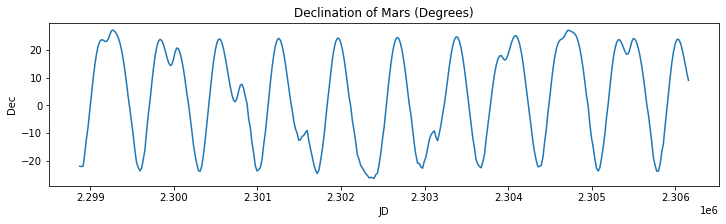

In [40]:
plt.figure(figsize=(12,3))
chart = sns.lineplot(
    data=dfMars, 
    x="JD",
    y="Dec")
chart.set_title("Declination of Mars (Degrees)")
# plt.savefig('plot.svg')

Text(0.5, 1.0, 'Alt of Mars (Degrees)')

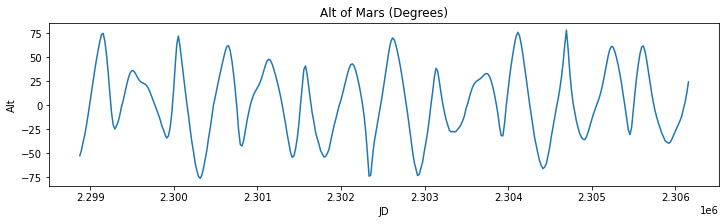

In [41]:
plt.figure(figsize=(12,3))
chart = sns.lineplot(
    data=dfMars, 
    x="JD",
    y="Alt")
chart.set_title("Alt of Mars (Degrees)")
# plt.savefig('plot.svg')

Text(0.5, 1.0, 'RA of Mars (Degrees)')

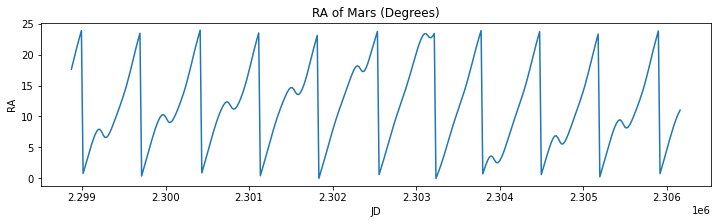

In [42]:
plt.figure(figsize=(12,3))
chart = sns.lineplot(
    data=dfMars, 
    x="JD",
    y="RA")
chart.set_title("RA of Mars (Degrees)")
# plt.savefig('plot.svg')

Text(0.5, 1.0, 'Az of Mars (Degrees)')

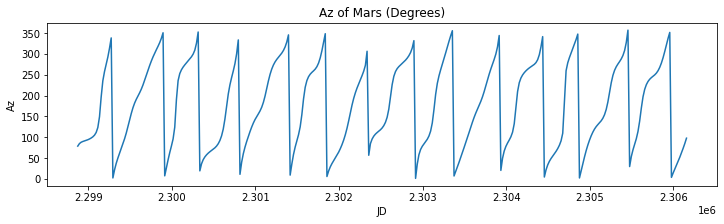

In [43]:
plt.figure(figsize=(12,3))
chart = sns.lineplot(
    data=dfMars, 
    x="JD",
    y="Az")
chart.set_title("Az of Mars (Degrees)")
# plt.savefig('plot.svg')

Text(0.5, 1.0, 'Declination of Mars (Degrees)')

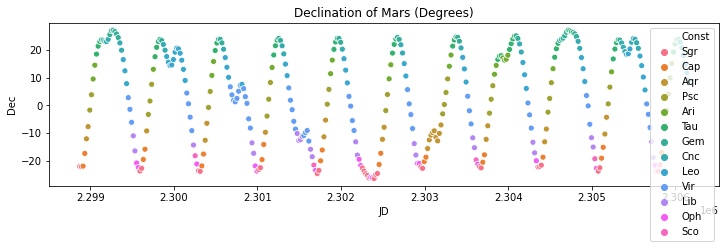

In [44]:
plt.figure(figsize=(12,3))
chart = sns.scatterplot(
    data=dfMars, 
    x="JD",
    y="Dec",
    hue="Const")
chart.set_title("Declination of Mars (Degrees)")

Text(0.5, 1.0, 'Distance between Mars and Earth (AU)')

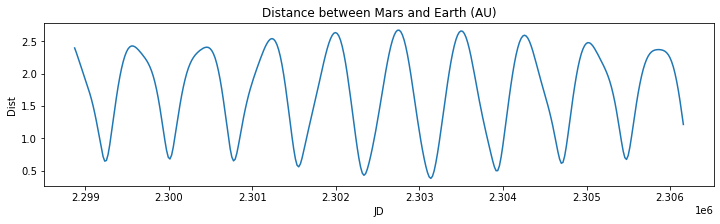

In [45]:
plt.figure(figsize=(12,3))
sns.lineplot(
    data=dfMars, 
    x="JD", 
    y="Dist").set_title("Distance between Mars and Earth (AU)")

## Linear Regression

In [63]:
dfMars = df.loc[df['Body'] == 'Mars']
X = pd.DataFrame(dfMars['JD'])
t = np.array(X['JD'])
T_ey = 365.25
T_my = 687
for omega in np.linspace(1, 2000, num=2000):
    X['sin'+str(omega)] = np.array(np.sin(omega*t))
    X['cos'+str(omega)] = np.array(np.cos(omega*t))
X = X.drop(['JD'], axis=1)
y = dfMars['Az']

In [64]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)

In [65]:
dfMarsplot = pd.DataFrame(dfMars['JD'].copy(),columns=['JD'])
dfMarsplot['Az'] = dfMars['Az']
dfMarsplot['Az_pred'] = y_pred
dfMarsplot

,JD,Az,Az_pred
2,2.298874e+06,78.874444,78.874444
11,2.298894e+06,84.888639,84.888639
20,2.298914e+06,88.125472,88.125472
29,2.298934e+06,89.936667,89.936667
38,2.298954e+06,91.246667,91.246667
...,...,...,...
3242,2.306078e+06,52.228167,52.228167
3251,2.306098e+06,62.732889,62.732889
3260,2.306118e+06,73.664500,73.664500
3269,2.306138e+06,85.171389,85.171389


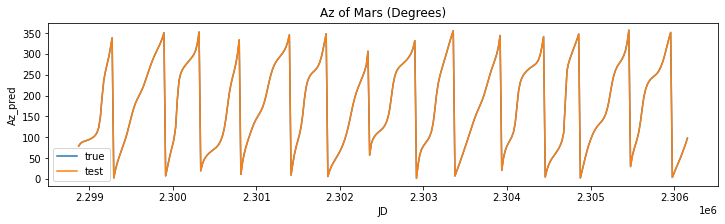

In [67]:
plt.figure(figsize=(12,3))

dfMarsplot

chart = sns.lineplot(
    data=dfMarsplot, 
    x='JD',
    y='Az'
)

chart = sns.lineplot(
    data=dfMarsplot, 
    x='JD',
    y='Az_pred'
)
chart.set_title("Az of Mars (Degrees)")
plt.legend(labels=['true', 'test'])


In [68]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y, y_pred)

1.6796016942737033e-25